#Importing the Libraries

In [1]:
import numpy as np
from numpy import array
#import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [2]:
## The sklearn libraries
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold

In [3]:
## The tensorflow libraries
import tensorflow as tf
#print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers


In [4]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

#Required variables ⭐

---



In [5]:
n_past_steps=60 ## past trading candles
n_next_steps=5 ## next trading candles
train_ratio=0.8 ## fraction of total data to be used as training data
target_scaling_factor=1000 ## The factor by which the target(close) prices will be scaled

#Uploading the file ⭐

In [6]:
from google.colab import files

uploaded = files.upload()
fn= uploaded.keys()

Saving Minute_bar_tracker (1).csv to Minute_bar_tracker (1).csv


In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Formatting the data

In [39]:
## For a particular file

df_input=pd.read_csv('/content/gdrive/MyDrive/Crude_data.csv')

df_input.dropna(inplace=True)
df_input.reset_index(drop=True, inplace=True)
#display(df_input)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
n_rows=df_input.shape[0]
n_cols=df_input.shape[1]
#print(df_input.dtypes)

In [41]:
# fig=plt.figure(figsize=(12,7))
# seaborn.heatmap(df_input.corr(), annot=True)
# plt.show()


**Target data**

In [42]:
## getting the target column vector
target_feature=pd.DataFrame()

## Running the loop for the columns
for i in range(0,n_next_steps,1):
  temp=pd.DataFrame(df_input.iloc[n_past_steps+i : n_rows - n_next_steps +i, 3:4])
  temp.reset_index(drop=True, inplace=True)
  target_feature=pd.concat([target_feature,temp], axis=1, ignore_index=True)


## scaling them by 1000 to avoid gradient explosion
target_feature=target_feature/target_scaling_factor
#display(target_feature)

**Test-Train Split + Standardising the data**

In [43]:
n_desired_train_size=int(np.floor(train_ratio*(n_rows - (n_past_steps + n_next_steps)))) ## desired train size
## We subtract n_past_steps as we do not have the target output for the last 60 combinations

x_scaler = preprocessing.StandardScaler().fit(df_input.iloc[0:n_rows-(n_past_steps + n_next_steps)])
x_scaled= pd.DataFrame(x_scaler.transform(df_input.iloc[0:n_rows-(n_past_steps + n_next_steps)]))
#print(x_scaled)


In [44]:
x_train=pd.DataFrame(x_scaled.iloc[0:n_desired_train_size])
x_test= pd.DataFrame(x_scaled.iloc[n_desired_train_size:n_rows-(n_past_steps + n_next_steps)])
#display(x_test_scaled)

**Making the sequence which will represent the input matrix**

In [45]:
def split_sequence(data, step_size):
  X =list()
  for i in range(len(data)):
    end_idx = i+ step_size

    ## Checking if we are out of dataset

    if(end_idx>=len(data)):
      break

    else:
      X.append(data.iloc[i:end_idx])

  return array(X)

In [46]:
x_train_scaled=split_sequence(x_train, n_past_steps)
x_test_scaled=split_sequence(x_test, n_past_steps)

In [47]:
#print(x_train_scaled.shape)

# The output shall be of the form (x,y,z) where 
# (a) x = number of data points to be used for training the model
# (b) y= number of past candles to predict the next candles
# (c) z= number of features used at each minute

In [48]:
y_train_scaled=pd.DataFrame(target_feature.iloc[0: x_train_scaled.shape[0]])
y_test_scaled= pd.DataFrame(target_feature.iloc[n_desired_train_size:n_desired_train_size+x_test_scaled.shape[0]])
#print(y_train_scaled.shape)


***Summary*** 

1.   x_train_scaled and y_train_scaled represent the train data
2.   x_test_scaled and y_test_scaled represent the test data


#Encoding the Model ⭐

In [19]:
from keras.layers import Dense, Activation, Flatten
initializer = tf.keras.initializers.GlorotNormal()

In [20]:
#Creating instance of the keras model
model= tf.keras.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=1, padding='same', activation='tanh', input_shape=(n_past_steps, n_cols), kernel_initializer=initializer))
model.add(layers.MaxPooling1D(pool_size=1,padding='same'))
model.add(layers.LSTM(units=64, activation='tanh', kernel_initializer=initializer))
model.add(layers.Dense(n_next_steps, activation='relu', kernel_initializer=initializer))
#model.summary()

In [21]:
#The important specifications
loss_fn=keras.losses.MeanSquaredError()
metrics_fn=keras.metrics.MeanAbsoluteError()
optim=keras.optimizers.Adam(learning_rate=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

#Training
batch_size=64
epochs=100

model.compile(optimizer=optim, loss=loss_fn, metrics=metrics_fn)

#Fitting and Training the model

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="/content/gdrive/My Drive/Predictive Analysis - Stellar Alpha/model/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                               verbose=0, mode='min',
                              save_best_only=True
                             )

callbacks_list = [callback, checkpoint]

Reference https://home.aveek.io/blog/post/checkpointing-keras-model/

In [ ]:
# Train the model with the new callback
model.fit(x_train_scaled, 
          y_train_scaled,
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks=callbacks_list,
          verbose=2, shuffle = False)

In [ ]:
y_pred=model.predict(x_train_scaled, batch_size=y_test_scaled.shape[0], verbose=0)

***Download the above checkpoint file once it is saved***

#Run the pre-trained model here ⭐

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/content/gdrive/My Drive/Predictive Analysis - Stellar Alpha/model/weights-13.hdf5") #Enter the location here checkpoint_path

In [ ]:
y_pred=model.predict(x_train_scaled, batch_size=batch_size, verbose=0)

#Evaluating the Model ⭐

In [ ]:
acc=model.evaluate(x_test_scaled, y_test_scaled)

1925/1925 [==============================] - 14s 7ms/step - loss: 7964.6621 - mean_absolute_error: 87.1184


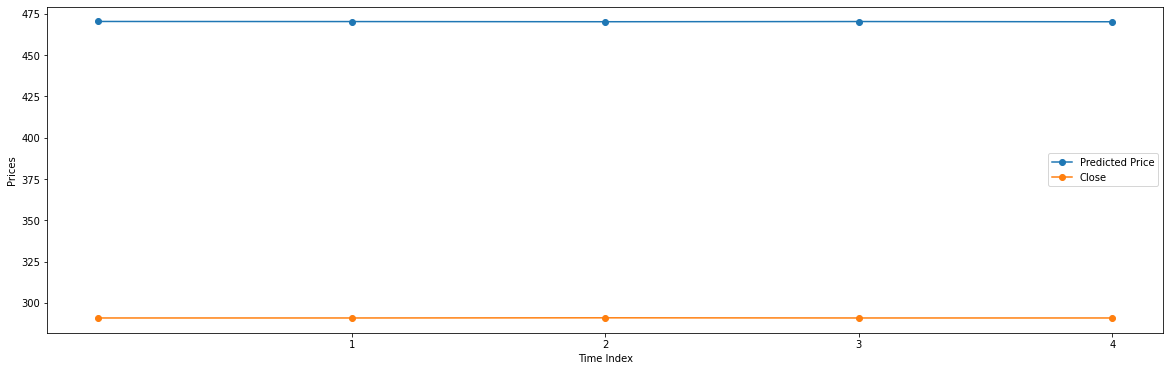

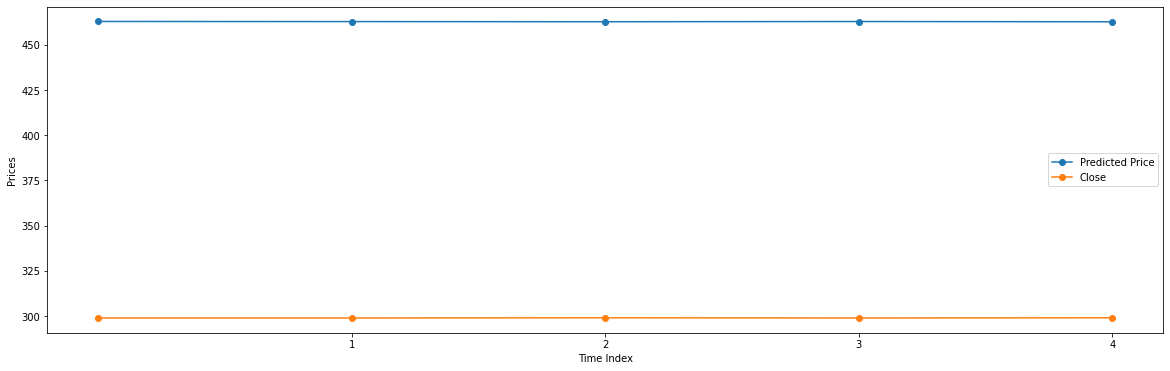

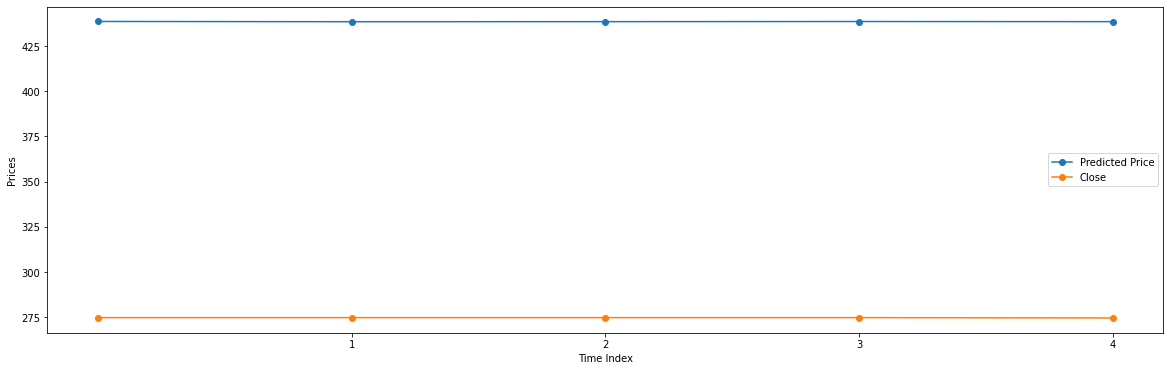

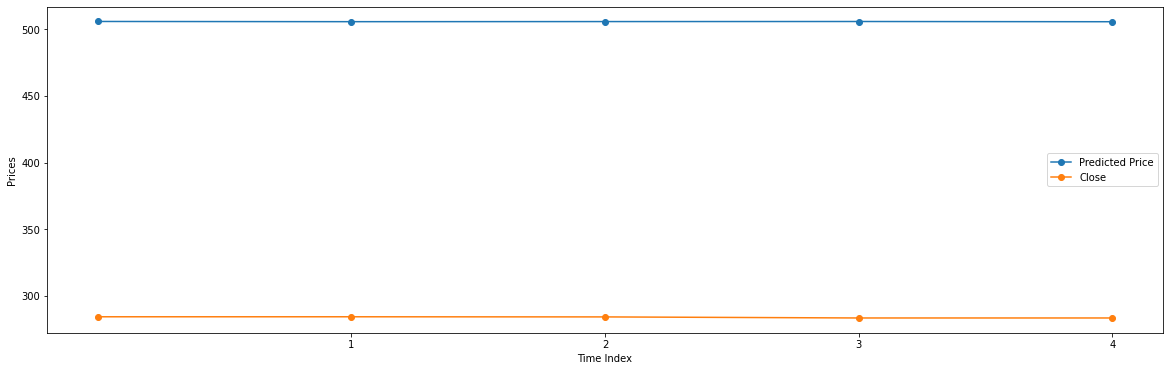

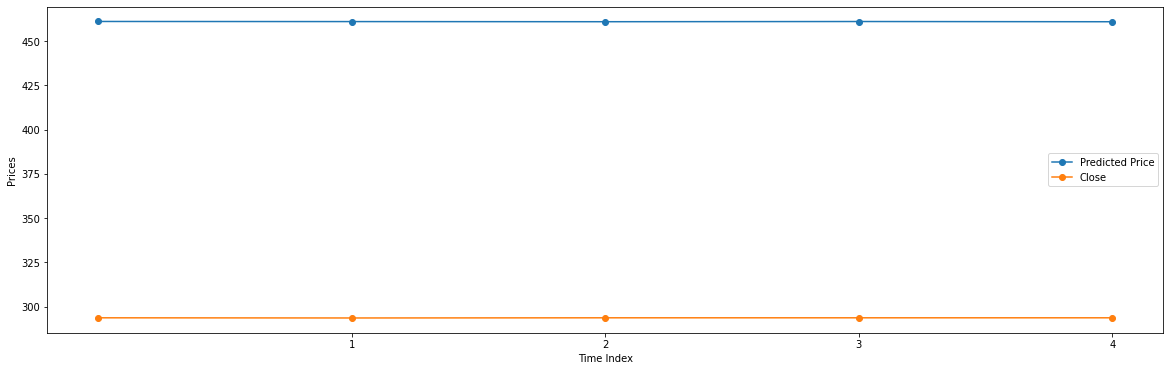

In [ ]:
import random
random_five=random.sample(range(0, y_test_scaled.shape[0]), 5)

for n in random_five:
  fig=plt.figure(figsize=(20,6))
  #plt.plot(df_input['Close'], label = "Close")
  #plt.axvline(x = int(df_input.shape[0]*train_ratio), color = 'r', label = 'Train-Test split')
  plt.plot(np.transpose(y_pred[n:n+1]*target_scaling_factor), label = "Predicted Price", marker='o')
  plt.plot(y_test_scaled[n:n+1].T*target_scaling_factor, label = "Close", marker='o')
  plt.xlabel("Time Index")
  plt.ylabel("Prices")
  plt.xticks(np.arange(1,5,1))
  plt.legend()
  plt.show()


In [ ]:
def get_momentum_accuracy(y_test, y_pred):
  y_pred=np.array(y_pred)
  y_test=np.array(y_test)

  n_jumps=y_test.shape[1]-1
  n_datapoints= y_test.shape[0]
  correct_momentum_predicted=0

  for n in range(n_datapoints):
    for i in range(n_jumps-1):
      if(y_test[n][i]< y_test[n][i+1] and y_pred[n][i]< y_pred[n][i+1]):
        correct_momentum_predicted+=1

      if(y_test[n][i]> y_test[n][i+1] and y_pred[n][i]> y_pred[n][i+1]):
        correct_momentum_predicted+=1

      if(y_test[n][i]== y_test[n][i+1] and y_pred[n][i]== y_pred[n][i+1]):
        correct_momentum_predicted+=1

      else:
        continue


  return correct_momentum_predicted*100/(n_jumps*n_datapoints)  

In [ ]:
print(get_momentum_accuracy(y_test_scaled, y_pred))